In [1]:
import sys
sys.path.append('..')
from src.utilities import *

# 4. Cluster Analysis

### 4.1 Store individual exhibits

In [2]:
master = pd.read_csv(os.path.join(processed_path, 'master.csv'))

model_01 = pd.read_pickle(os.path.join(models_path, 'model2_quantile_0.1.pkl'))
model_05 =  pd.read_pickle(os.path.join(models_path, 'model2_quantile_0.5.pkl'))
model_09 =  pd.read_pickle(os.path.join(models_path, 'model2_quantile_0.9.pkl'))

master['preds_01'] = model_01.predict(master.drop(columns = ['month', 'region', 'brand', 'sales']))
master['preds_05'] = model_05.predict(master.drop(columns = ['month', 'region', 'brand', 'sales', 'preds_01']))
master['preds_09'] = model_09.predict(master.drop(columns = ['month', 'region', 'brand', 'sales', 'preds_01', 'preds_05']))

master = master[['month', 'region', 'brand', 'sales', 'preds_01', 'preds_05', 'preds_09']]
master.to_excel(os.path.join(results_path, 'individual_exhibits.xlsx'))
master.head()

,month,region,brand,sales,preds_01,preds_05,preds_09
0,2020-01,region_0,brand_1,0.0,0.0,0.192997,1777.795225
1,2020-01,region_0,brand_2,0.0,0.0,0.192997,1777.795225
2,2020-01,region_1,brand_1,0.0,0.0,0.192997,1036.565433
3,2020-01,region_1,brand_2,0.0,0.0,0.192997,1036.565433
4,2020-01,region_2,brand_1,0.0,0.0,0.192997,835.570964


### 4.2 Perform sales clustering

In [3]:
from sklearn.cluster import KMeans

cluster_data = master[master.brand == 'brand_1'].groupby(['region', 'brand', 'month']).preds_05.mean().unstack().reset_index()
km = KMeans(15)
km.fit(cluster_data.drop(columns = ['region', 'brand']))
cluster_data['cluster'] = km.predict(cluster_data.drop(columns = ['region', 'brand']))
cluster_data['cluster'].value_counts()

8     35
3     31
6     28
5     27
1     22
14    16
11    10
0      9
7      6
4      5
10     3
12     3
9      3
13     2
2      1
Name: cluster, dtype: int64

******************************
**********CLUSTER 5
******************************
Number of regions 27
Average sales 2071.652911954258
Forecast uncertainty 232.80347592877752


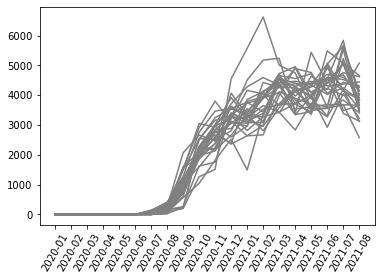

******************************
**********CLUSTER 1
******************************
Number of regions 22
Average sales 1199.1673943945193
Forecast uncertainty 184.25569720661943


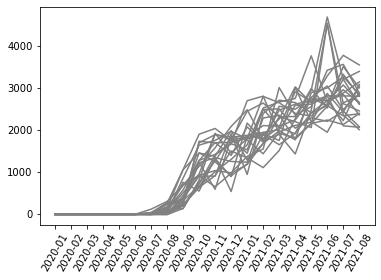

******************************
**********CLUSTER 3
******************************
Number of regions 31
Average sales 396.05590225451965
Forecast uncertainty 153.82933988641608


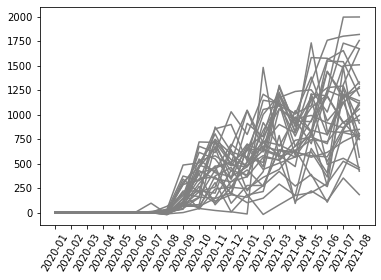

******************************
**********CLUSTER 6
******************************
Number of regions 28
Average sales 1581.3292551619381
Forecast uncertainty 214.4528576500618


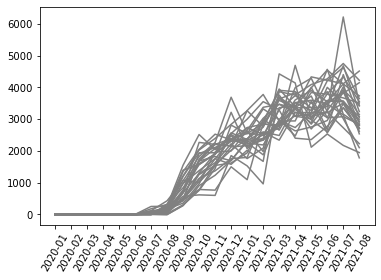

******************************
**********CLUSTER 8
******************************
Number of regions 35
Average sales 839.4110135771767
Forecast uncertainty 174.78849548864406


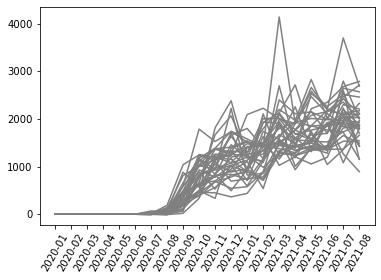

******************************
**********CLUSTER 14
******************************
Number of regions 16
Average sales 2704.367178803304
Forecast uncertainty 271.61827324375133


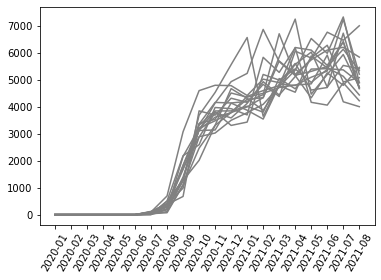

******************************
**********CLUSTER 0
******************************
Number of regions 9
Average sales 2295.418883010345
Forecast uncertainty 237.3800052598899


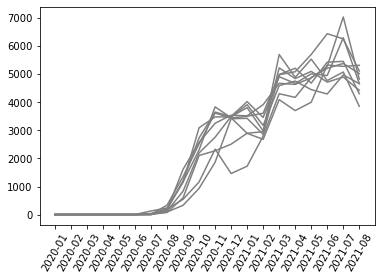

******************************
**********CLUSTER 11
******************************
Number of regions 10
Average sales 3026.2382774165326
Forecast uncertainty 363.38353077871415


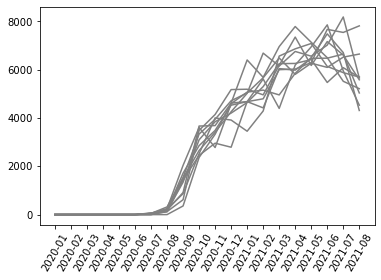

******************************
**********CLUSTER 13
******************************
Number of regions 2
Average sales 4647.134226262018
Forecast uncertainty 400.0784504933793


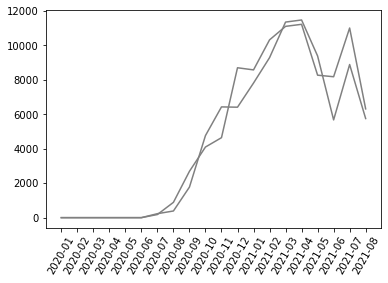

******************************
**********CLUSTER 10
******************************
Number of regions 3
Average sales 5300.365827145129
Forecast uncertainty 604.3212196992155


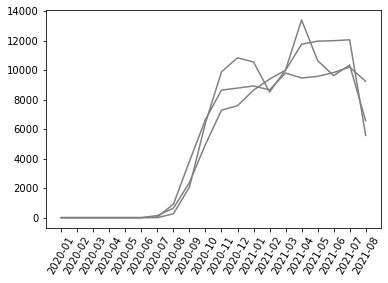

******************************
**********CLUSTER 4
******************************
Number of regions 5
Average sales 4026.7506001100955
Forecast uncertainty 462.6266275758474


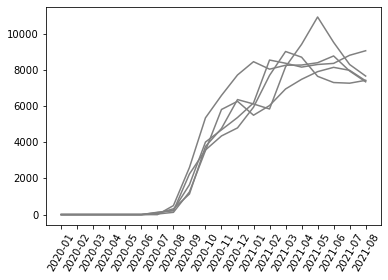

******************************
**********CLUSTER 12
******************************
Number of regions 3
Average sales 3602.7025794265587
Forecast uncertainty 341.12298439619485


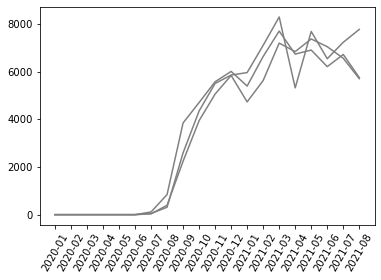

******************************
**********CLUSTER 7
******************************
Number of regions 6
Average sales 3197.7223593149865
Forecast uncertainty 406.514900301863


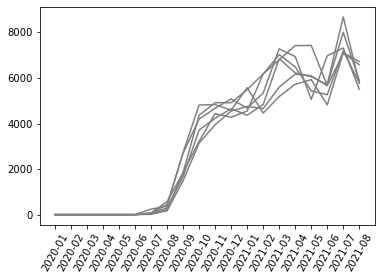

******************************
**********CLUSTER 9
******************************
Number of regions 3
Average sales 3564.8836426059183
Forecast uncertainty 525.1203619085364


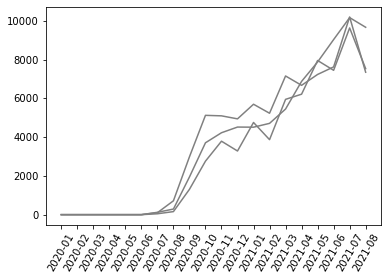

******************************
**********CLUSTER 2
******************************
Number of regions 1
Average sales 6175.33303319626
Forecast uncertainty 620.0709355355086


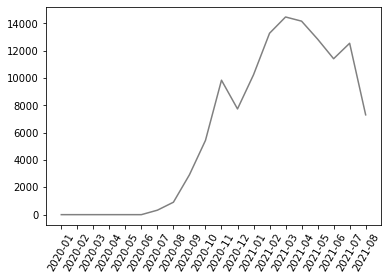

In [4]:
master['uncertainty'] = abs(master['preds_09'] - master['preds_05']) / (master['preds_05']+1)
for cluster in cluster_data.cluster.unique():
    print('*'*30)
    print('*'*10 + 'CLUSTER', cluster)
    print('*'*30)
    current = cluster_data[cluster_data.cluster == cluster].reset_index(drop = True)
    print('Number of regions', current.shape[0])
    print('Average sales', current.drop(columns = ['region', 'brand','cluster']).mean(axis = 1).mean())
    print('Forecast uncertainty', current.merge(master.groupby(['region', 'brand']).uncertainty.mean().reset_index(), 
                                                how = 'left', on = ['region', 'brand']).uncertainty.mean() )
    for i in range(current.shape[0]):
        plt.plot(current.drop(columns = ['region', 'brand','cluster']).iloc[i], color = 'gray')
        plt.xticks(rotation=60)
    plt.show()

In [3]:
master.head()

,month,region,brand,sales,preds_01,preds_05,preds_09
0,2020-01,region_0,brand_1,0.0,-0.218591,-16.470957,721.648552
1,2020-01,region_0,brand_2,0.0,-0.218591,-16.470957,721.648552
2,2020-01,region_1,brand_1,0.0,-0.523428,-8.659845,661.898228
3,2020-01,region_1,brand_2,0.0,-0.523428,-8.659845,661.898228
4,2020-01,region_2,brand_1,0.0,-0.494502,-8.659845,655.191906


In [4]:
master.head()

,month,region,brand,sales,preds_01,preds_05,preds_09
0,2020-01,region_0,brand_1,0.0,-0.218591,-16.470957,721.648552
1,2020-01,region_0,brand_2,0.0,-0.218591,-16.470957,721.648552
2,2020-01,region_1,brand_1,0.0,-0.523428,-8.659845,661.898228
3,2020-01,region_1,brand_2,0.0,-0.523428,-8.659845,661.898228
4,2020-01,region_2,brand_1,0.0,-0.494502,-8.659845,655.191906


In [10]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(master):
    print(master.iloc[train_index].shape)

(6432, 7)
(6432, 7)
(6432, 7)
(6432, 7)
(6432, 7)
